In [1]:
import sys
sys.path.append('../xrun')

In [2]:
import re

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from IPython.core.display import HTML
from sklearn.metrics import pairwise_distances

from xrun.data.run_info import RunInfo

In [3]:
def load_cost_from_file(file_path: Path):
    if file_path.exists():
            with open(file_path, "r") as f:
                return float(f.read())
    else:
        # print(f"Warning: {file_path} not found!")
        pass
    return None

def get_algorithm_name(run_info):
    if run_info.algorithm == "basic-clustering":
        return "StreamKM++ (buggy)"
    elif run_info.algorithm == "sensitivity-sampling":
        return "Sensitivity Sampling"
    elif run_info.algorithm == "group-sampling":
        return "Group Sampling"
    elif run_info.algorithm == "bico":
        return "BICO"
    elif run_info.algorithm == "stream-km++":
        return "StreamKM++"
    elif run_info.algorithm == "ray-maker":
        return "Ray Maker"
    return "Unknown"

def get_dataset_print_name(run_info):
    d = {
        "census": "Census",
        "censuslowd": "Census+PCA",
        "covertype": "Covertype",
        "covertypelowd": "Covertype+PCA",
        "tower": "Tower",
        "hardinstanceb1": "Benchmark",
        "hardinstanceb15": "Benchmark-1.5",
        "hardinstanceb2": "Benchmark-2.0",
        "oldhardinstanceb1": "Old Benchmark",
        "oldhardinstanceb2": "Old Benchmark-2.0",
        "caltech101": "Caltech",
        "caltech101lowd": "Caltech+PCA",
        "oldcaltech101": "Old Caltech",
        "nytimes100d": "NYTimes",
        "nytimespcalowd": "NYTimes+PCA",
    }
    if run_info.dataset in d:
        return d[run_info.dataset]
    return run_info.dataset
    

def get_costs(file_paths):
    costs = []
    for index, run_file_path in enumerate(file_paths):
        run_info = RunInfo.load_json(run_file_path)
        if "hardinstance" in run_info.dataset and run_info.k > 40:
            continue
        real_cost = load_cost_from_file(run_file_path.parent / "real_cost.txt")
        coreset_cost = load_cost_from_file(run_file_path.parent / "coreset_cost.txt")
        distortion = None
        if real_cost is not None and coreset_cost is not None:
            distortion = max(float(real_cost/coreset_cost), float(coreset_cost/real_cost))
        costs.append({
            "dataset": get_dataset_print_name(run_info),
            "algorithm": get_algorithm_name(run_info),
            "k": run_info.k,
            "running_time": int(run_info.duration_secs),
            "real_cost": real_cost,
            "coreset_cost": coreset_cost,
            "distortion": distortion,
            "run_file_path": str(run_file_path),
        })
    df_data = pd.DataFrame(costs)
    return df_data.groupby(["dataset", "algorithm", "k"], as_index=False).head(10)

def aggregate_costs(df_costs: pd.DataFrame):
    group_columns = ["dataset", "algorithm", "k"]
    df_top_k = df_costs.groupby(group_columns, as_index=False).head(10)
    df_aggr_costs = df_top_k.groupby(group_columns, as_index=False).agg(
        experiment_count=("algorithm", "count"),
        real_cost_mean=("real_cost", "mean"),
        real_cost_std=("real_cost", "std"),
        coreset_cost_mean=("coreset_cost", "mean"),
        coreset_cost_std=("coreset_cost", "std"),
        running_time_mean=("running_time", "mean"),
        running_time_std=("running_time", "std"),
        distortion_mean=("distortion", "mean"),
        distortion_median=("distortion", "median"),
        distortion_std=("distortion", "std"),
        distortion_max=("distortion", "max"),
    )
    df_aggr_costs["running_time"] = pd.to_timedelta(df_aggr_costs.running_time_mean, unit='s')
    df_aggr_costs["running_time_formatted"] = df_aggr_costs["running_time"].map(
        lambda x: f"{x.components.hours:02d}h {x.components.minutes:02d}m {x.components.seconds:02d}s"
    )
    return df_aggr_costs


def display_results_for(df_aggr_costs: pd.DataFrame, dataset_name: str, show_counts: bool=True, show_running_times:bool=True, show_costs: bool=True):
    pd.set_option('display.float_format', '{:.2e}'.format)
    
    display(HTML(f"<h2 style='border-bottom:solid 1px Black;padding-bottom:5px;'>Results for {dataset_name}</h2>"))
    df_filtered = df_aggr_costs[df_aggr_costs.dataset == dataset_name]
    
    html_str = ""
    
    if show_counts:
        df_counts = pd.pivot_table(df_filtered, values="experiment_count", index=["algorithm"], columns=["k"])
        df_counts = df_counts.rename_axis(None, axis=0).rename_axis(None, axis=1)
        html_str += f'<div style="border:solid 1px White; width:300px;float:left;">'
        html_str += f"<h4 style='text-align:center;'>Experiment Counts</h4>"
        html_str += df_counts.style.format(precision=0).to_html()
        html_str += "</div>"
    
    if show_running_times:
        df_run_times = pd.pivot_table(df_filtered, values="running_time_formatted", index=["algorithm"], columns=["k"], aggfunc=lambda x: x)
        df_run_times = df_run_times.rename_axis(None, axis=0).rename_axis(None, axis=1)

        html_str += f'<div style="border:solid 1px White; float:left;">'
        html_str += f"<h4 style='text-align:center;'>Average Running Times</h4>"
        html_str += df_run_times.to_html()
        html_str += "</div>"
        
    display(HTML(html_str))

    if show_costs:
        df_real_costs = pd.pivot_table(df_filtered, values="real_cost_mean", index=["algorithm"], columns=["k"])
        df_real_costs = df_real_costs.rename_axis(None, axis=0).rename_axis(None, axis=1)
        
        df_coreset_costs = pd.pivot_table(df_filtered, values="coreset_cost_mean", index=["algorithm"], columns=["k"])
        df_coreset_costs = df_coreset_costs.rename_axis(None, axis=0).rename_axis(None, axis=1)
        
        html_str = ""
        html_str += f'<div style="border:solid 1px #eee; float:left;">'
        html_str += f"<h4 style='text-align:center;'>Real costs</h4>"
        html_str += df_real_costs.to_html()
        html_str += "</div>"
        
        html_str += f'<div style="border:solid 1px #eee; float:left;">'
        html_str += f"<h4 style='text-align:center;'>Coreset costs</h4>"
        html_str += df_coreset_costs.to_html()
        html_str += "</div>"
        display(HTML(html_str))
    
    display(HTML(f'<h4>Distortions</h4>'))
    df_distortions = pd.pivot_table(df_filtered, values="distortion_max", index=["algorithm"], columns=["k"])
    df_distortions = df_distortions.rename_axis(None, axis=0).rename_axis(None, axis=1)
    display(df_distortions)

In [4]:
data_results_dir = Path("../data/skadi-results/")
run_files = list(data_results_dir.glob("**/*.json"))

In [5]:
len(run_files)

3227

In [6]:
df_cost_data = get_costs(run_files)

In [7]:
include_datasets = [
    'Caltech', 'Caltech+PCA', 'Census', 'Census+PCA', 'Covertype', 'Covertype+PCA', 
    'Tower', 'NYTimes', 'NYTimes+PCA', 
    # 'Benchmark-1.0', 'Benchmark-1.5', 'Benchmark-2.0',
    'Benchmark',
]
include_algorithms = [
    'StreamKM++', 'Group Sampling', 'Ray Maker', 'BICO', 'Sensitivity Sampling', 
    # 'StreamKM++ (buggy)'
]
df_cost_filtered = df_cost_data[df_cost_data.algorithm.isin(include_algorithms) & df_cost_data.dataset.isin(include_datasets)]
#df_cost_filtered = df_cost_data[df_cost_data.algorithm.isin(include_algorithms)]

In [8]:
df_aggr_costs = aggregate_costs(df_cost_filtered)

In [9]:
for dataset_name in df_aggr_costs.dataset.unique():
    display_results_for(df_aggr_costs, dataset_name=dataset_name, show_counts=True, show_running_times=False, show_costs=True)

,10,20,30,40
BICO,10,10,10,10
Group Sampling,10,10,10,10
Ray Maker,10,10,10,10
Sensitivity Sampling,10,10,10,10
StreamKM++,10,10,10,10


,10,20,30,40
BICO,4.64e+06,1.31e+07,2.69e+06,9.05e+06
Group Sampling,5.44e+06,1.52e+07,3.06e+06,9.86e+06
Ray Maker,5.24e+06,1.38e+07,2.51e+06,8.90e+06
Sensitivity Sampling,4.50e+06,1.22e+07,2.35e+06,7.49e+06
StreamKM++,5.30e+06,1.56e+07,3.15e+06,1.08e+07
,10,20,30,40
BICO,1.59e+06,4.57e+06,1.15e+06,3.42e+06
Group Sampling,5.38e+06,1.50e+07,3.01e+06,9.70e+06
Ray Maker,1.50e+06,3.54e+06,5.98e+05,2.33e+06
Sensitivity Sampling,4.57e+06,1.24e+07,2.40e+06,7.66e+06


,10,20,30,40
BICO,3.21e+00,3.11e+00,2.44e+00,3.00e+00
Group Sampling,1.02e+00,1.02e+00,1.02e+00,1.02e+00
Ray Maker,3.57e+00,4.08e+00,4.36e+00,4.03e+00
Sensitivity Sampling,1.02e+00,1.02e+00,1.03e+00,1.03e+00
StreamKM++,1.05e+00,1.11e+00,1.10e+00,1.18e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,4.01e+11,3.70e+11,3.54e+11,3.44e+11,3.36e+11
Group Sampling,3.96e+11,3.63e+11,3.46e+11,3.35e+11,3.27e+11
Ray Maker,4.02e+11,3.72e+11,3.55e+11,3.44e+11,3.36e+11
Sensitivity Sampling,3.95e+11,3.63e+11,3.46e+11,3.35e+11,3.27e+11
StreamKM++,3.95e+11,3.63e+11,3.46e+11,3.35e+11,3.28e+11
,10,20,30,40,50
BICO,9.76e+10,9.08e+10,8.60e+10,8.31e+10,8.53e+10
Group Sampling,3.88e+11,3.56e+11,3.39e+11,3.28e+11,3.20e+11
Ray Maker,8.06e+10,7.67e+10,7.44e+10,7.28e+10,7.11e+10
Sensitivity Sampling,3.92e+11,3.58e+11,3.42e+11,3.31e+11,3.22e+11


,10,20,30,40,50
BICO,4.97e+00,5.62e+00,5.10e+00,4.90e+00,5.50e+00
Group Sampling,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.02e+00
Ray Maker,5.20e+00,5.07e+00,4.92e+00,4.85e+00,4.86e+00
Sensitivity Sampling,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.01e+00
StreamKM++,1.11e+00,1.13e+00,1.13e+00,1.13e+00,1.14e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,4.03e+11,3.68e+11,3.53e+11,3.45e+11,3.35e+11
Group Sampling,4.01e+11,3.65e+11,3.48e+11,3.36e+11,3.27e+11
Ray Maker,4.04e+11,3.71e+11,3.55e+11,3.44e+11,3.36e+11
Sensitivity Sampling,4.01e+11,3.65e+11,3.47e+11,3.36e+11,3.27e+11
StreamKM++,4.00e+11,3.65e+11,3.47e+11,3.36e+11,3.28e+11
,10,20,30,40,50
BICO,3.47e+11,2.60e+11,2.04e+11,1.62e+11,1.41e+11
Group Sampling,3.97e+11,3.60e+11,3.42e+11,3.30e+11,3.22e+11
Ray Maker,3.40e+11,2.46e+11,1.94e+11,1.60e+11,1.35e+11
Sensitivity Sampling,4.00e+11,3.63e+11,3.44e+11,3.33e+11,3.24e+11


,10,20,30,40,50
BICO,1.17e+00,1.44e+00,1.80e+00,2.27e+00,2.57e+00
Group Sampling,1.01e+00,1.02e+00,1.02e+00,1.02e+00,1.02e+00
Ray Maker,1.21e+00,1.52e+00,1.85e+00,2.19e+00,2.52e+00
Sensitivity Sampling,1.01e+00,1.01e+00,1.01e+00,1.01e+00,1.01e+00
StreamKM++,1.03e+00,1.05e+00,1.06e+00,1.08e+00,1.09e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,2.48e+08,1.90e+08,1.61e+08,1.42e+08,1.29e+08
Group Sampling,2.56e+08,1.94e+08,1.64e+08,1.46e+08,1.31e+08
Ray Maker,2.50e+08,1.91e+08,1.58e+08,1.42e+08,1.29e+08
Sensitivity Sampling,2.71e+08,1.97e+08,1.65e+08,1.47e+08,1.34e+08
StreamKM++,2.51e+08,1.93e+08,1.59e+08,1.43e+08,1.34e+08
,10,20,30,40,50
BICO,1.51e+08,1.09e+08,9.12e+07,7.77e+07,6.92e+07
Group Sampling,2.49e+08,1.89e+08,1.60e+08,1.43e+08,1.28e+08
Ray Maker,1.44e+08,1.09e+08,8.83e+07,7.87e+07,6.98e+07
Sensitivity Sampling,2.75e+08,1.99e+08,1.67e+08,1.48e+08,1.35e+08


,10,20,30,40,50
BICO,1.83e+00,1.83e+00,1.87e+00,1.91e+00,1.98e+00
Group Sampling,1.04e+00,1.03e+00,1.03e+00,1.02e+00,1.03e+00
Ray Maker,1.80e+00,1.81e+00,1.85e+00,1.85e+00,1.95e+00
Sensitivity Sampling,1.03e+00,1.02e+00,1.02e+00,1.02e+00,1.01e+00
StreamKM++,1.06e+00,1.07e+00,1.08e+00,1.08e+00,1.27e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,2.52e+08,1.90e+08,1.60e+08,1.41e+08,1.28e+08
Group Sampling,2.58e+08,1.97e+08,1.64e+08,1.45e+08,1.30e+08
Ray Maker,2.50e+08,1.92e+08,1.59e+08,1.42e+08,1.28e+08
Sensitivity Sampling,2.67e+08,2.01e+08,1.70e+08,1.45e+08,1.33e+08
StreamKM++,2.56e+08,1.93e+08,1.62e+08,1.42e+08,1.28e+08
,10,20,30,40,50
BICO,2.13e+08,1.32e+08,9.73e+07,7.96e+07,6.88e+07
Group Sampling,2.54e+08,1.93e+08,1.60e+08,1.42e+08,1.27e+08
Ray Maker,2.08e+08,1.32e+08,9.78e+07,8.07e+07,7.07e+07
Sensitivity Sampling,2.71e+08,2.04e+08,1.72e+08,1.46e+08,1.34e+08


,10,20,30,40,50
BICO,1.20e+00,1.51e+00,1.72e+00,1.84e+00,1.95e+00
Group Sampling,1.02e+00,1.02e+00,1.03e+00,1.02e+00,1.03e+00
Ray Maker,1.23e+00,1.49e+00,1.67e+00,1.79e+00,1.85e+00
Sensitivity Sampling,1.03e+00,1.03e+00,1.02e+00,1.01e+00,1.02e+00
StreamKM++,1.02e+00,1.04e+00,1.06e+00,1.07e+00,1.08e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,3.44e+11,2.05e+11,1.56e+11,1.30e+11,1.14e+11
Group Sampling,3.49e+11,2.08e+11,1.57e+11,1.31e+11,1.15e+11
Ray Maker,3.46e+11,2.08e+11,1.58e+11,1.32e+11,1.16e+11
Sensitivity Sampling,3.51e+11,2.08e+11,1.59e+11,1.32e+11,1.15e+11
StreamKM++,3.43e+11,2.06e+11,1.56e+11,1.30e+11,1.14e+11
,10,20,30,40,50
BICO,3.11e+11,1.84e+11,1.41e+11,1.20e+11,1.06e+11
Group Sampling,3.42e+11,2.02e+11,1.54e+11,1.28e+11,1.12e+11
Ray Maker,2.93e+11,1.72e+11,1.29e+11,1.08e+11,9.51e+10
Sensitivity Sampling,3.56e+11,2.08e+11,1.59e+11,1.34e+11,1.16e+11


,10,20,30,40,50
BICO,1.11e+00,1.12e+00,1.11e+00,1.09e+00,1.07e+00
Group Sampling,1.05e+00,1.04e+00,1.03e+00,1.03e+00,1.03e+00
Ray Maker,1.21e+00,1.24e+00,1.24e+00,1.24e+00,1.23e+00
Sensitivity Sampling,1.03e+00,1.02e+00,1.02e+00,1.02e+00,1.01e+00
StreamKM++,1.02e+00,1.02e+00,1.02e+00,1.01e+00,1.01e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,3.42e+11,2.06e+11,1.56e+11,1.30e+11,1.14e+11
Group Sampling,3.47e+11,2.08e+11,1.58e+11,1.32e+11,1.15e+11
Ray Maker,3.49e+11,2.06e+11,1.58e+11,1.32e+11,1.16e+11
Sensitivity Sampling,3.48e+11,2.08e+11,1.58e+11,1.32e+11,1.15e+11
StreamKM++,3.43e+11,2.05e+11,1.57e+11,1.30e+11,1.14e+11
,10,20,30,40,50
BICO,3.09e+11,1.85e+11,1.42e+11,1.19e+11,1.06e+11
Group Sampling,3.37e+11,2.03e+11,1.54e+11,1.28e+11,1.12e+11
Ray Maker,2.93e+11,1.71e+11,1.30e+11,1.08e+11,9.43e+10
Sensitivity Sampling,3.54e+11,2.11e+11,1.59e+11,1.32e+11,1.16e+11


,10,20,30,40,50
BICO,1.11e+00,1.12e+00,1.11e+00,1.09e+00,1.07e+00
Group Sampling,1.05e+00,1.04e+00,1.04e+00,1.04e+00,1.03e+00
Ray Maker,1.21e+00,1.23e+00,1.23e+00,1.24e+00,1.24e+00
Sensitivity Sampling,1.04e+00,1.03e+00,1.02e+00,1.02e+00,1.01e+00
StreamKM++,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.01e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,2.81e+08,2.74e+08,2.69e+08,2.63e+08,2.59e+08
Group Sampling,2.80e+08,2.73e+08,2.66e+08,2.60e+08,2.55e+08
Ray Maker,2.80e+08,2.75e+08,2.71e+08,2.66e+08,2.64e+08
Sensitivity Sampling,2.80e+08,2.72e+08,2.65e+08,2.61e+08,2.56e+08
StreamKM++,2.83e+08,2.76e+08,2.71e+08,2.66e+08,2.61e+08
,10,20,30,40,50
BICO,1.61e+07,2.80e+07,3.51e+07,4.19e+07,4.35e+07
Group Sampling,2.70e+08,2.63e+08,2.57e+08,2.52e+08,2.47e+08
Ray Maker,1.83e+07,2.17e+07,2.23e+07,2.39e+07,2.44e+07
Sensitivity Sampling,2.76e+08,2.69e+08,2.61e+08,2.58e+08,2.53e+08


,10,20,30,40,50
BICO,3.07e+01,1.31e+01,1.35e+01,7.24e+00,6.73e+00
Group Sampling,1.04e+00,1.04e+00,1.04e+00,1.04e+00,1.03e+00
Ray Maker,1.65e+01,1.34e+01,1.39e+01,1.32e+01,1.20e+01
Sensitivity Sampling,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.01e+00
StreamKM++,1.92e+00,1.73e+00,1.72e+00,1.66e+00,1.68e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,2.67e+08,2.62e+08,2.59e+08,2.56e+08,2.53e+08
Group Sampling,2.67e+08,2.62e+08,2.58e+08,2.55e+08,2.53e+08
Ray Maker,2.68e+08,2.62e+08,2.59e+08,2.56e+08,2.54e+08
Sensitivity Sampling,2.67e+08,2.62e+08,2.58e+08,2.55e+08,2.54e+08
StreamKM++,2.67e+08,2.62e+08,2.59e+08,2.56e+08,2.53e+08
,10,20,30,40,50
BICO,2.65e+08,2.57e+08,2.51e+08,2.46e+08,2.43e+08
Group Sampling,2.67e+08,2.61e+08,2.58e+08,2.54e+08,2.52e+08
Ray Maker,2.65e+08,2.56e+08,2.51e+08,2.46e+08,2.41e+08
Sensitivity Sampling,2.67e+08,2.62e+08,2.58e+08,2.56e+08,2.53e+08


,10,20,30,40,50
BICO,1.01e+00,1.02e+00,1.03e+00,1.04e+00,1.05e+00
Group Sampling,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
Ray Maker,1.01e+00,1.03e+00,1.03e+00,1.05e+00,1.06e+00
Sensitivity Sampling,1.00e+00,1.00e+00,1.00e+00,1.01e+00,1.00e+00
StreamKM++,1.00e+00,1.01e+00,1.01e+00,1.01e+00,1.02e+00


,20,40,60,80,100
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,20,40,60,80,100
BICO,6.23e+08,3.33e+08,2.44e+08,1.93e+08,1.64e+08
Group Sampling,6.47e+08,3.39e+08,2.45e+08,1.97e+08,1.67e+08
Ray Maker,6.23e+08,3.34e+08,2.42e+08,1.93e+08,1.63e+08
Sensitivity Sampling,6.47e+08,3.45e+08,2.49e+08,1.98e+08,1.68e+08
StreamKM++,6.25e+08,3.32e+08,2.42e+08,1.93e+08,1.64e+08
,20,40,60,80,100
BICO,5.85e+08,3.13e+08,2.30e+08,1.84e+08,1.57e+08
Group Sampling,6.33e+08,3.31e+08,2.37e+08,1.91e+08,1.61e+08
Ray Maker,5.86e+08,3.16e+08,2.30e+08,1.84e+08,1.56e+08
Sensitivity Sampling,6.61e+08,3.51e+08,2.52e+08,1.99e+08,1.69e+08


,20,40,60,80,100
BICO,1.07e+00,1.07e+00,1.06e+00,1.05e+00,1.05e+00
Group Sampling,1.03e+00,1.03e+00,1.04e+00,1.04e+00,1.04e+00
Ray Maker,1.07e+00,1.06e+00,1.06e+00,1.05e+00,1.05e+00
Sensitivity Sampling,1.04e+00,1.03e+00,1.02e+00,1.02e+00,1.02e+00
StreamKM++,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.02e+00


In [10]:
colors = sns.color_palette("tab10")
algorithm_colors = {algo: colors[i] for i, algo in enumerate(df_aggr_costs.algorithm.unique())}

In [11]:
df_aggr_costs["k_formatted"] = "$k$=" + df_aggr_costs["k"].astype(str)

In [12]:
def combine_mean_and_std(row) -> str:
    mean = row["distortion_mean"]
    std =  row["distortion_std"]
    return f"{mean:0.2f} ({std:0.3f})"

df_aggr_costs["distortion_mean_std"] = df_aggr_costs.apply(lambda x: combine_mean_and_std(x), axis=1)

df_results_table = pd.pivot_table(
    data=df_aggr_costs,
    values="distortion_mean_std",
    index=["dataset", "k"],
    columns=["algorithm"],
    aggfunc=lambda x: ' '.join(x)
)

df_results_table

algorithm                   BICO Group Sampling      Ray Maker  \
dataset       k                                                  
Benchmark     10    2.93 (0.144)   1.01 (0.002)   3.49 (0.055)   
              20    2.87 (0.137)   1.01 (0.002)   3.90 (0.112)   
              30    2.34 (0.070)   1.02 (0.001)   4.19 (0.137)   
              40    2.68 (0.230)   1.02 (0.001)   3.83 (0.172)   
Caltech       10    4.15 (0.485)   1.02 (0.003)   4.99 (0.124)   
              20    4.16 (0.708)   1.02 (0.003)   4.86 (0.134)   
              30    4.15 (0.416)   1.02 (0.001)   4.78 (0.117)   
              40    4.18 (0.486)   1.02 (0.002)   4.73 (0.068)   
              50    3.99 (0.560)   1.02 (0.002)   4.72 (0.090)   
Caltech+PCA   10    1.16 (0.004)   1.01 (0.002)   1.19 (0.009)   
              20    1.42 (0.016)   1.01 (0.002)   1.51 (0.008)   
              30    1.73 (0.045)   1.02 (0.001)   1.83 (0.014)   
              40    2.13 (0.083)   1.02 (0.002)   2.16 (0.016)   
              50    2.38 (0.139)   1.02 (0.001)   2.49 (0.017)   
Census        10    1.65 (0.082)   1.03 (0.011)   1.74 (0.044)   
              20    1.74 (0.054)   1.02 (0.004)   1.75 (0.038)   
              30    1.77 (0.063)   1.02 (0.003)   1.79 (0.032)   
              40    1.83 (0.038)   1.02 (0.002)   1.81 (0.021)   
              50    1.87 (0.088)   1.02 (0.002)   1.85 (0.044)   
Census+PCA    10    1.18 (0.012)   1.01 (0.005)   1.20 (0.016)   
              20    1.44 (0.046)   1.02 (0.003)   1.45 (0.019)   
              30    1.64 (0.044)   1.02 (0.004)   1.63 (0.021)   
              40    1.77 (0.035)   1.02 (0.002)   1.76 (0.028)   
              50    1.87 (0.068)   1.02 (0.002)   1.82 (0.017)   
Covertype     10    1.10 (0.002)   1.03 (0.011)   1.18 (0.016)   
              20    1.11 (0.004)   1.03 (0.010)   1.21 (0.015)   
              30    1.10 (0.003)   1.03 (0.005)   1.22 (0.008)   
              40    1.09 (0.001)   1.03 (0.005)   1.22 (0.012)   
              50    1.07 (0.001)   1.03 (0.003)   1.22 (0.008)   
Covertype+PCA 10    1.11 (0.003)   1.03 (0.012)   1.19 (0.011)   
              20    1.11 (0.003)   1.03 (0.006)   1.21 (0.010)   
              30    1.10 (0.002)   1.03 (0.007)   1.22 (0.011)   
              40    1.09 (0.002)   1.03 (0.006)   1.23 (0.010)   
              50    1.07 (0.001)   1.03 (0.003)   1.23 (0.008)   
NYTimes       10   18.59 (5.356)   1.04 (0.003)  15.37 (0.740)   
              20    9.98 (1.559)   1.04 (0.003)  12.71 (0.448)   
              30    8.03 (2.156)   1.04 (0.002)  12.18 (0.974)   
              40    6.31 (0.436)   1.03 (0.003)  11.20 (0.742)   
              50    5.97 (0.381)   1.03 (0.002)  10.81 (0.571)   
NYTimes+PCA   10    1.01 (0.000)   1.00 (0.000)   1.01 (0.001)   
              20    1.02 (0.000)   1.00 (0.000)   1.02 (0.001)   
              30    1.03 (0.000)   1.00 (0.000)   1.03 (0.001)   
              40    1.04 (0.001)   1.00 (0.000)   1.04 (0.001)   
              50    1.04 (0.002)   1.00 (0.000)   1.05 (0.001)   
Tower         20    1.07 (0.003)   1.02 (0.007)   1.06 (0.004)   
              40    1.06 (0.004)   1.02 (0.006)   1.06 (0.002)   
              60    1.06 (0.001)   1.03 (0.004)   1.05 (0.004)   
              80    1.05 (0.001)   1.03 (0.005)   1.05 (0.002)   
              100   1.04 (0.002)   1.03 (0.004)   1.05 (0.001)   

algorithm         Sensitivity Sampling    StreamKM++  
dataset       k                                       
Benchmark     10          1.02 (0.003)  1.04 (0.002)  
              20          1.02 (0.003)  1.11 (0.002)  
              30          1.02 (0.002)  1.10 (0.002)  
              40          1.02 (0.002)  1.17 (0.004)  
Caltech       10          1.01 (0.004)  1.10 (0.004)  
              20          1.01 (0.003)  1.12 (0.004)  
              30          1.01 (0.002)  1.13 (0.003)  
              40          1.01 (0.002)  1.13 (0.001)  
              50          1.01 (0.002)  1.13 (0.002)  
Caltech+PCA   10          1.

In [13]:
print(df_results_table.to_latex())

\begin{tabular}{lllllll}
\toprule
      & algorithm &           BICO & Group Sampling &      Ray Maker & Sensitivity Sampling &    StreamKM++ \\
dataset & k &                &                &                &                      &               \\
\midrule
Benchmark & 10  &   2.93 (0.144) &   1.01 (0.002) &   3.49 (0.055) &         1.02 (0.003) &  1.04 (0.002) \\
      & 20  &   2.87 (0.137) &   1.01 (0.002) &   3.90 (0.112) &         1.02 (0.003) &  1.11 (0.002) \\
      & 30  &   2.34 (0.070) &   1.02 (0.001) &   4.19 (0.137) &         1.02 (0.002) &  1.10 (0.002) \\
      & 40  &   2.68 (0.230) &   1.02 (0.001) &   3.83 (0.172) &         1.02 (0.002) &  1.17 (0.004) \\
Caltech & 10  &   4.15 (0.485) &   1.02 (0.003) &   4.99 (0.124) &         1.01 (0.004) &  1.10 (0.004) \\
      & 20  &   4.16 (0.708) &   1.02 (0.003) &   4.86 (0.134) &         1.01 (0.003) &  1.12 (0.004) \\
      & 30  &   4.15 (0.416) &   1.02 (0.001) &   4.78 (0.117) &         1.01 (0.002) &  1.13 (0.003) \\


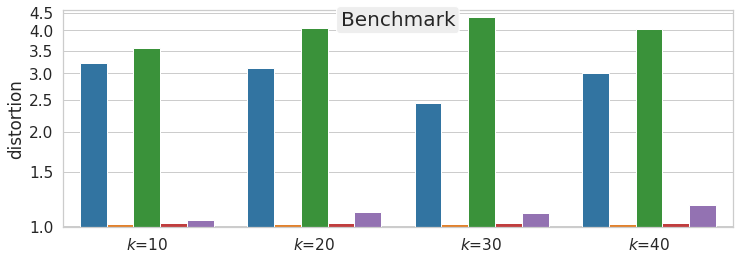

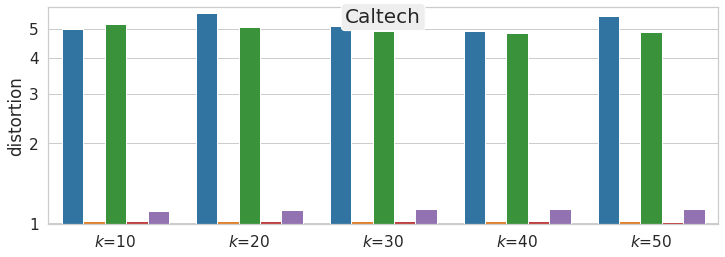

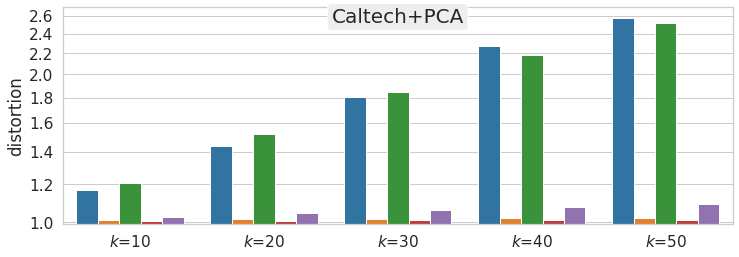

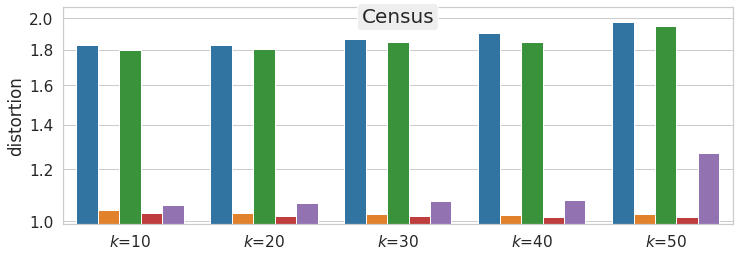

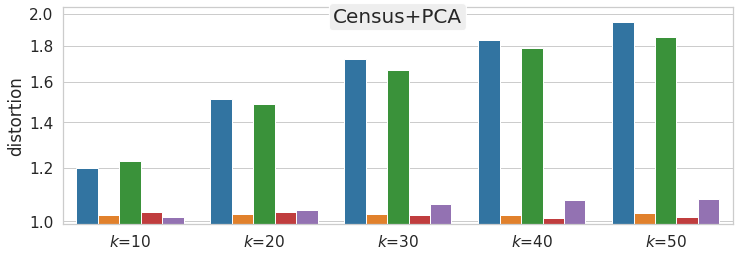

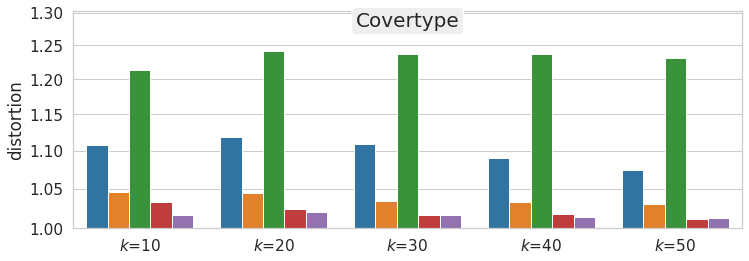

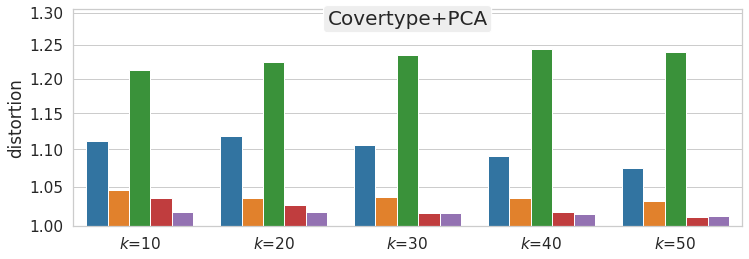

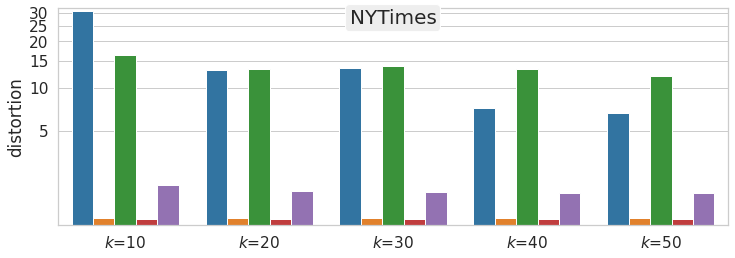

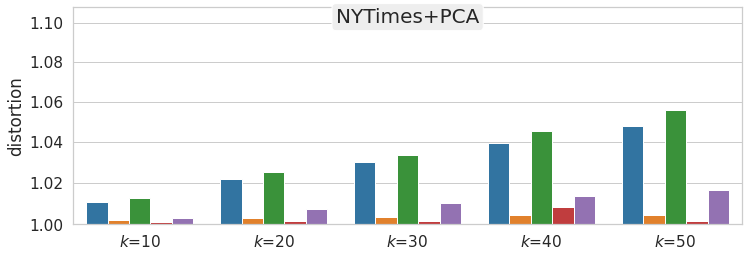

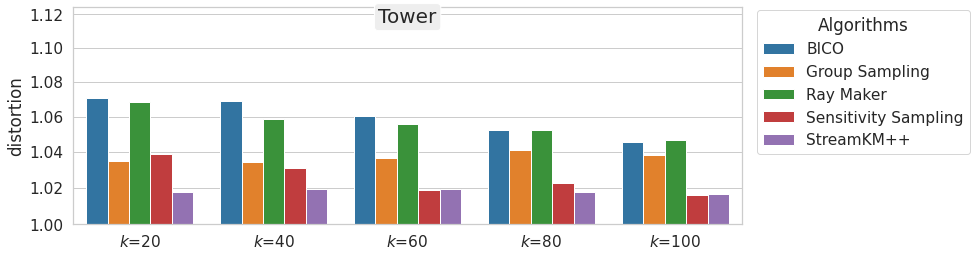

In [14]:
forward = lambda x: x**(1/10)
inverse = lambda x: x**10

with sns.plotting_context("notebook", font_scale=1.4):
    for dataset in df_aggr_costs.dataset.unique():
        is_tower = dataset == "Tower"
        df_filtered = df_aggr_costs[df_aggr_costs.dataset == dataset]
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion_max", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, y=0.9, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("distortion")
        ax.set_xlabel("")
        ax.set_yscale('function', functions=(forward, inverse))
        
        if dataset == "NYTimes":
            ax.set_ylim(bottom=0.9)
        elif dataset in ["NYTimes+PCA", "Tower", "Covertype", "Covertype+PCA"]:
            ax.set_ylim(bottom=1)
        else:
            ax.set_ylim(bottom=0.99)
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        if is_tower:
           ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
           ax.get_legend().remove()
        
        # fig.savefig(f"figures-skadi/distortions-{dataset}.pdf", bbox_inches="tight")

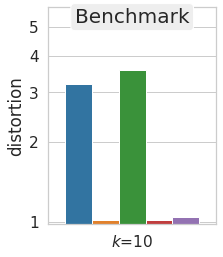

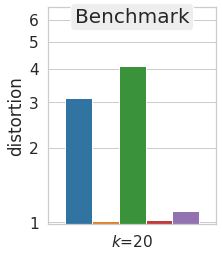

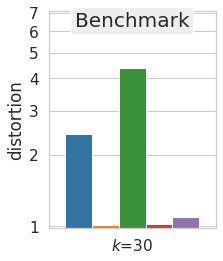

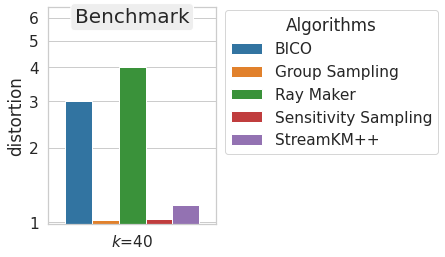

In [15]:
with sns.plotting_context("notebook", font_scale=1.4):
    dataset = "Benchmark"
    for k in [10, 20, 30, 40]:
        filter_benchmark = df_aggr_costs.dataset == dataset
        filter_k = df_aggr_costs.k == k
        df_filtered = df_aggr_costs[filter_benchmark & filter_k]
        fig, ax = plt.subplots(figsize=(3, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion_max", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, y=0.9, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("distortion")
        ax.set_xlabel("")
        ax.set_yscale('function', functions=(forward, inverse))
        
        ax.set_ylim(bottom=0.98)
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        if k == 40:
           ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
           ax.get_legend().remove()
        # fig.savefig(f"figures-skadi/distortions-{dataset}-k{k}.pdf", bbox_inches="tight")

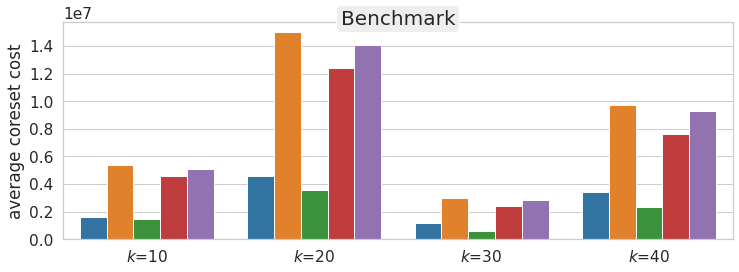

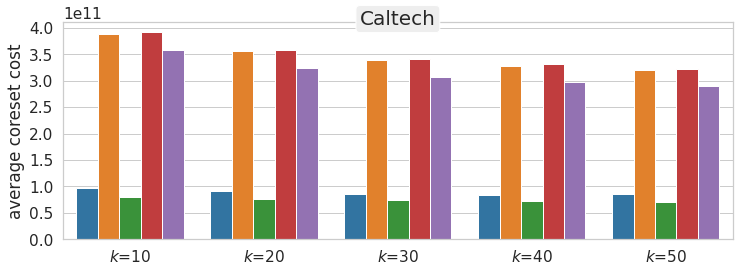

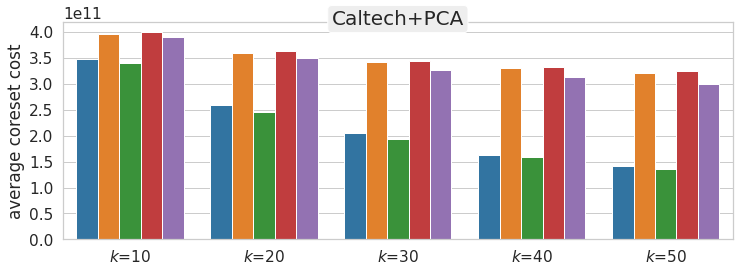

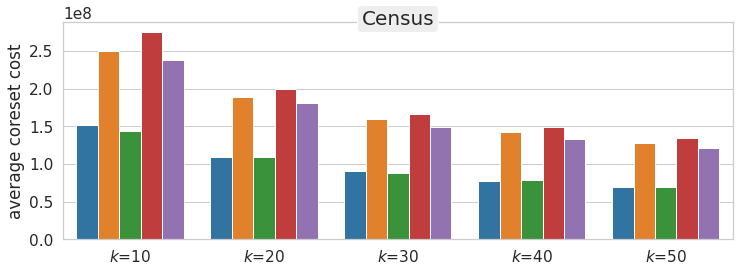

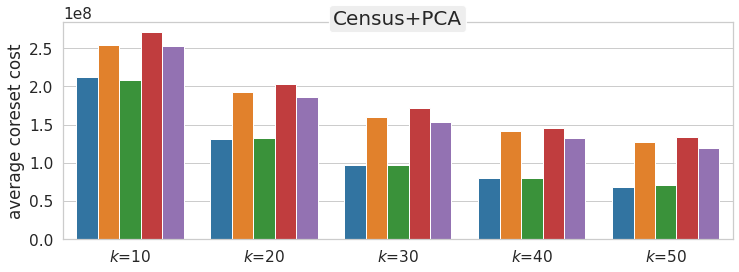

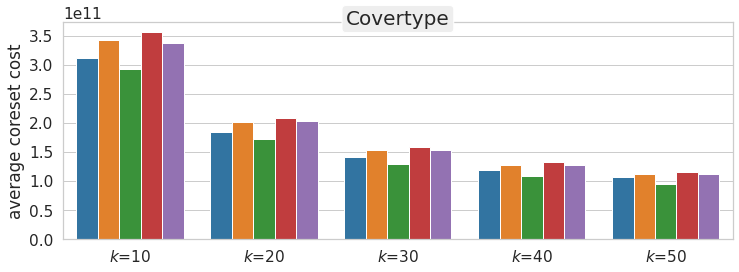

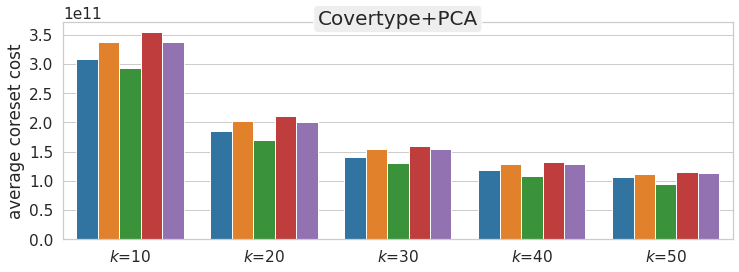

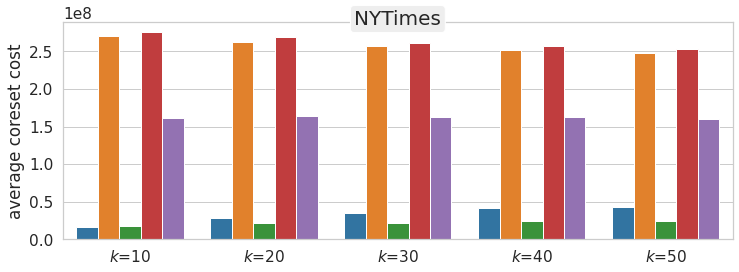

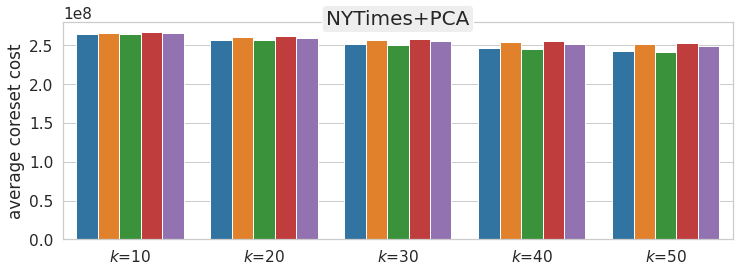

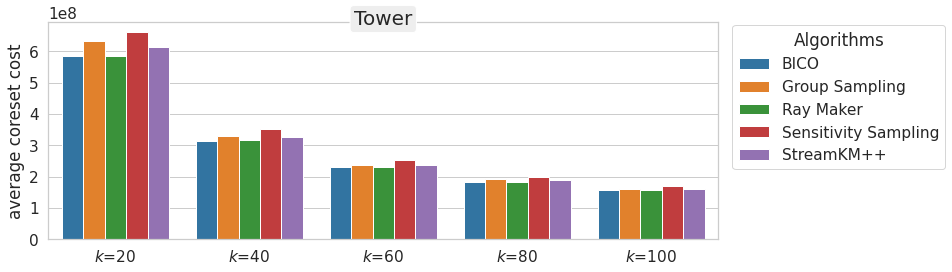

In [16]:
with sns.plotting_context("notebook", font_scale=1.4):
    for dataset in df_aggr_costs.dataset.unique():
        is_tower = dataset == "Tower"
        df_filtered = df_aggr_costs[df_aggr_costs.dataset == dataset]
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="coreset_cost_mean", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, y=0.96, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("average coreset cost")
        ax.set_xlabel("")
        if is_tower:
           ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
           ax.get_legend().remove()
        # fig.savefig(f"figures-skadi/coreset-costs-{dataset}.pdf", bbox_inches="tight")

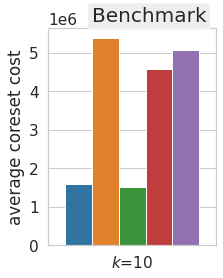

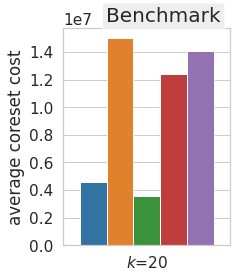

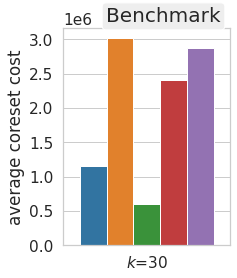

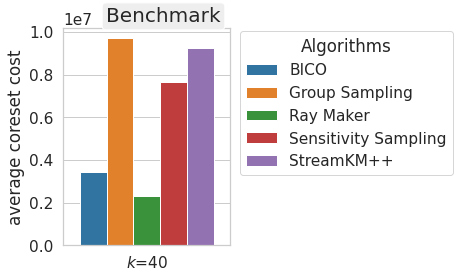

In [17]:
with sns.plotting_context("notebook", font_scale=1.4):
    dataset = "Benchmark"
    for k in [10, 20, 30, 40]:
        filter_benchmark = df_aggr_costs.dataset == dataset
        filter_k = df_aggr_costs.k == k
        df_filtered = df_aggr_costs[filter_benchmark & filter_k]
        fig, ax = plt.subplots(figsize=(3, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="coreset_cost_mean", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, x=0.6, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("average coreset cost")
        ax.set_xlabel("")
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        if k == 40:
           ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
           ax.get_legend().remove()
        # fig.savefig(f"figures-skadi/coreset-costs-{dataset}-k{k}.pdf", bbox_inches="tight")

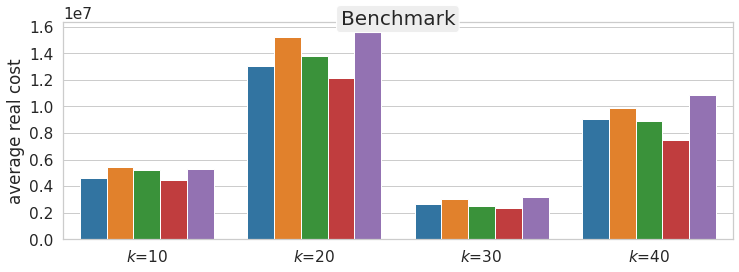

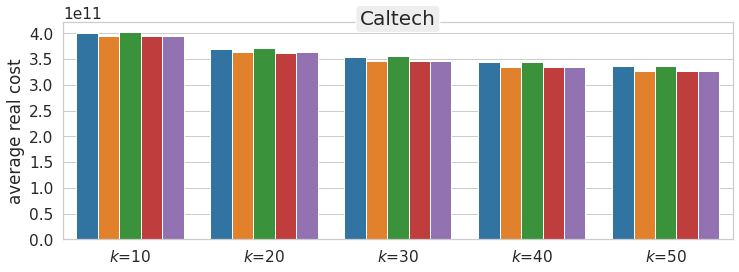

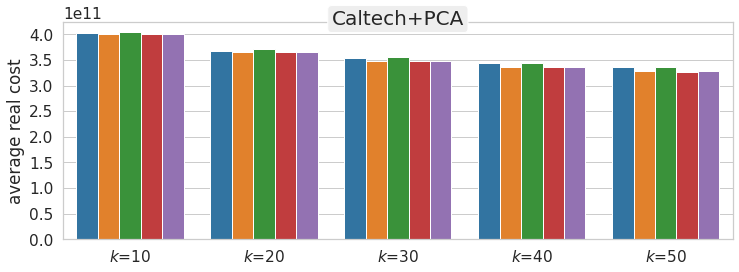

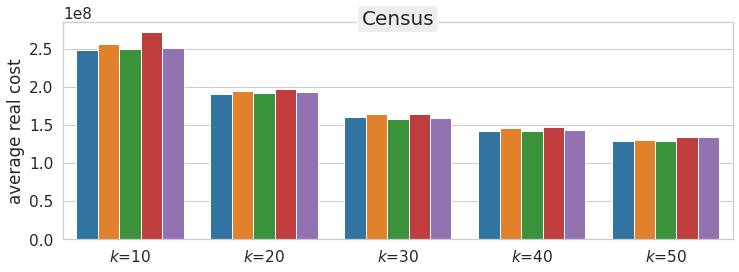

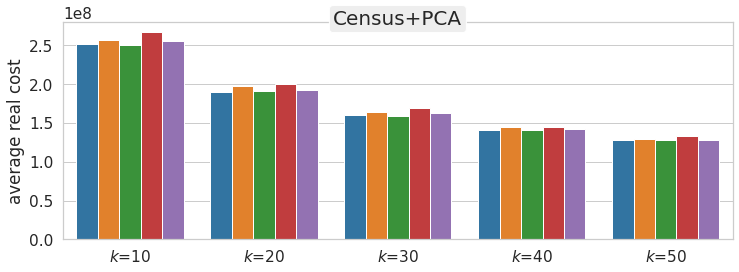

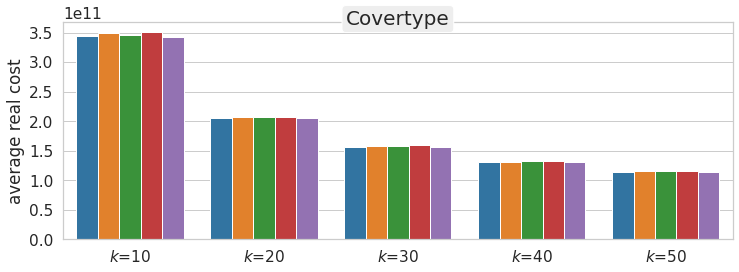

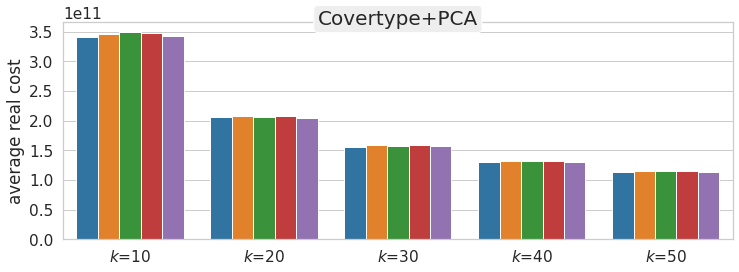

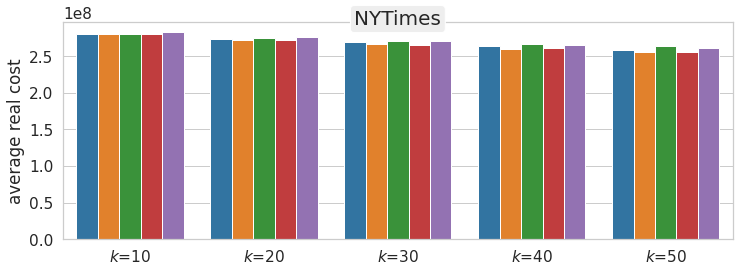

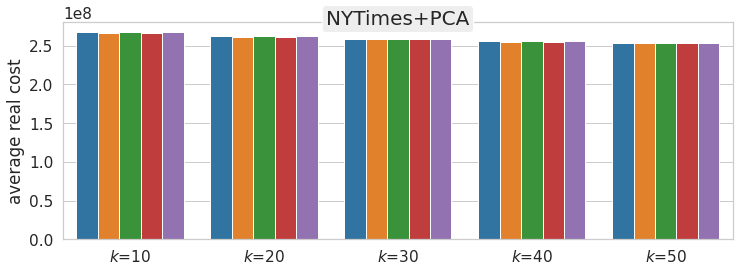

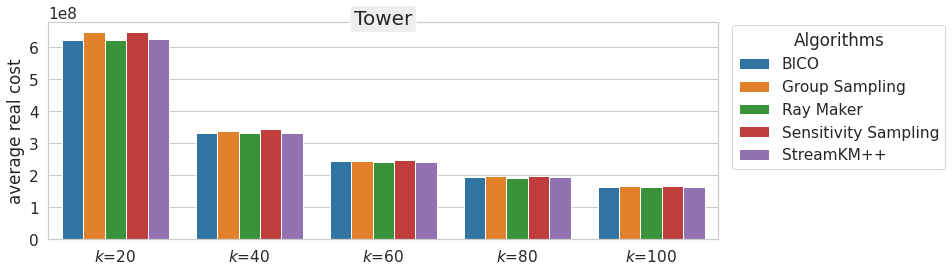

In [18]:
with sns.plotting_context("notebook", font_scale=1.4):
    for dataset in df_aggr_costs.dataset.unique():
        is_tower = dataset == "Tower"
        df_filtered = df_aggr_costs[df_aggr_costs.dataset == dataset]
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="real_cost_mean", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, y=0.96, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("average real cost")
        ax.set_xlabel("")
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        if is_tower:
           ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
           ax.get_legend().remove()
        # fig.savefig(f"figures-skadi/real-costs-{dataset}.pdf", bbox_inches="tight")

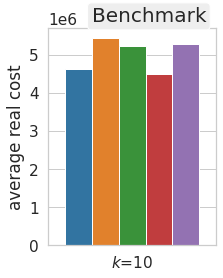

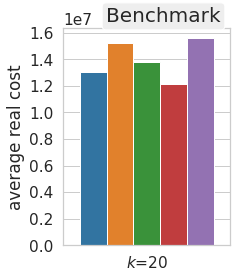

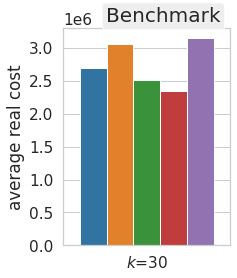

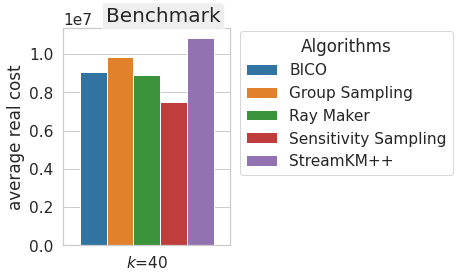

In [19]:
with sns.plotting_context("notebook", font_scale=1.4):
    dataset = "Benchmark"
    for k in [10, 20, 30, 40]:
        filter_benchmark = df_aggr_costs.dataset == dataset
        filter_k = df_aggr_costs.k == k
        df_filtered = df_aggr_costs[filter_benchmark & filter_k]
        fig, ax = plt.subplots(figsize=(3, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="real_cost_mean", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, x=0.6, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("average real cost")
        ax.set_xlabel("")
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        if k == 40:
           ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
           ax.get_legend().remove()
        # fig.savefig(f"figures-skadi/real-costs-{dataset}-k{k}.pdf", bbox_inches="tight")

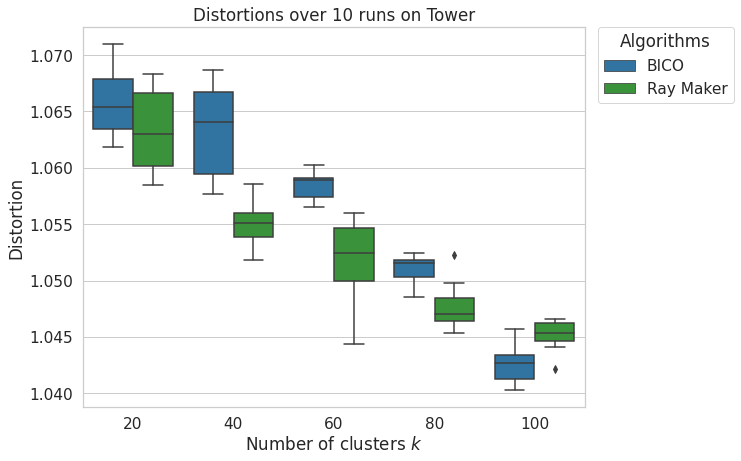

In [20]:
con_census = df_cost_data.dataset == 'Tower'
cond_ray_maker = df_cost_data.algorithm == 'Ray Maker' 
cond_bico = df_cost_data.algorithm == 'BICO' 
cond_skm = df_cost_data.algorithm == 'StreamKM++' 
df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico)].copy()
df_filtered.sort_values(by="algorithm", inplace=True)

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.boxplot(x="k", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    ax.set_xlabel("Number of clusters $k$")
    ax.set_ylabel("Distortion")
    ax.set_title(f"Distortions over 10 runs on {df_filtered.dataset.unique()[0]}");
    # fig.savefig(f"figures-skadi/Tower-distortions-BICO-and-Ray-Maker.pdf", bbox_inches="tight")

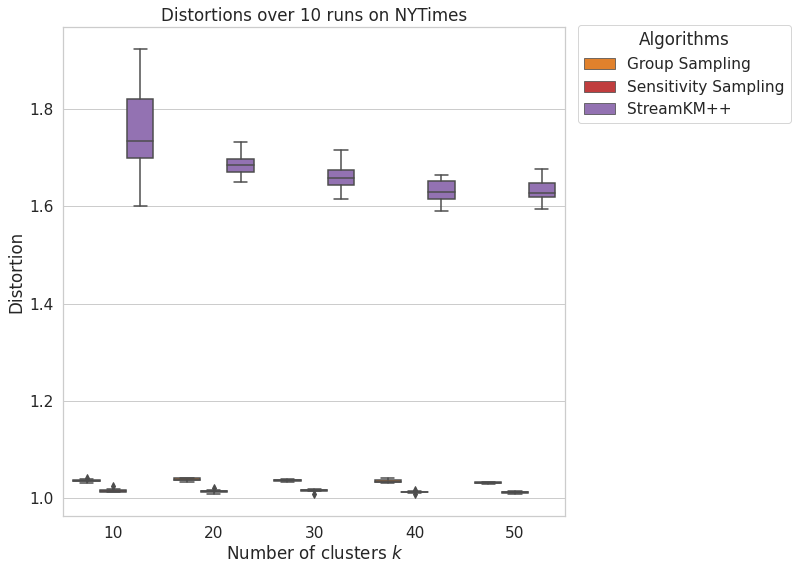

In [21]:
con_census = df_cost_data.dataset == 'NYTimes'
cond_ray_maker = df_cost_data.algorithm == 'Sensitivity Sampling'
cond_bico = df_cost_data.algorithm == 'Group Sampling'
cond_skm = df_cost_data.algorithm == 'StreamKM++' 
df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico | cond_skm)].copy()
df_filtered.sort_values(by="algorithm", inplace=True)

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(9, 9))
    sns.boxplot(x="k", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.set_xlabel("Number of clusters $k$")
    ax.set_ylabel("Distortion")
    ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    ax.set_title(f"Distortions over 10 runs on {df_filtered.dataset.unique()[0]}");
    # fig.savefig(f"figures-skadi/NYTimes+RP-distortions-GS-SS-StreamKM.pdf", bbox_inches="tight")

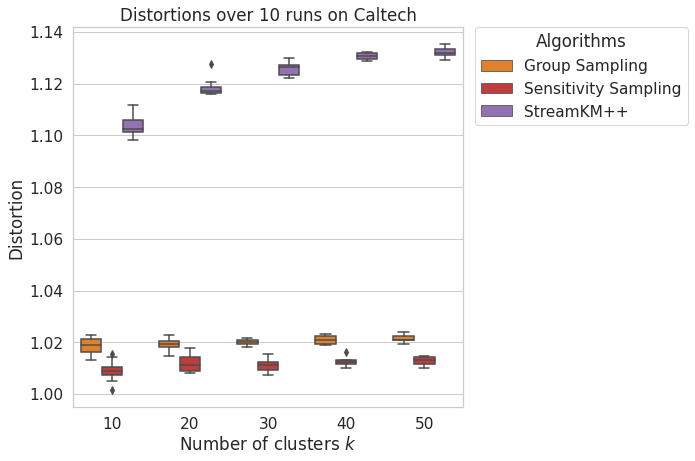

In [22]:
con_census = df_cost_data.dataset == 'Caltech'
cond_ray_maker = df_cost_data.algorithm == 'Sensitivity Sampling'
cond_bico = df_cost_data.algorithm == 'Group Sampling'
cond_skm = df_cost_data.algorithm == 'StreamKM++' 
df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico | cond_skm)].copy()
df_filtered.sort_values(by="algorithm", inplace=True)

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.boxplot(x="k", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.set_xlabel("Number of clusters $k$")
    ax.set_ylabel("Distortion")
    ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    ax.set_title(f"Distortions over 10 runs on {df_filtered.dataset.unique()[0]}");
    # fig.savefig(f"figures-skadi/Caltech-distortions-GS-SS-StreamKM.pdf", bbox_inches="tight")

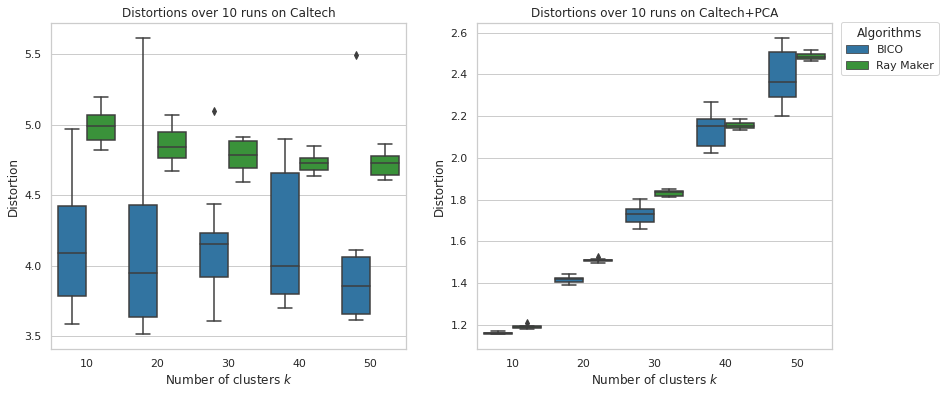

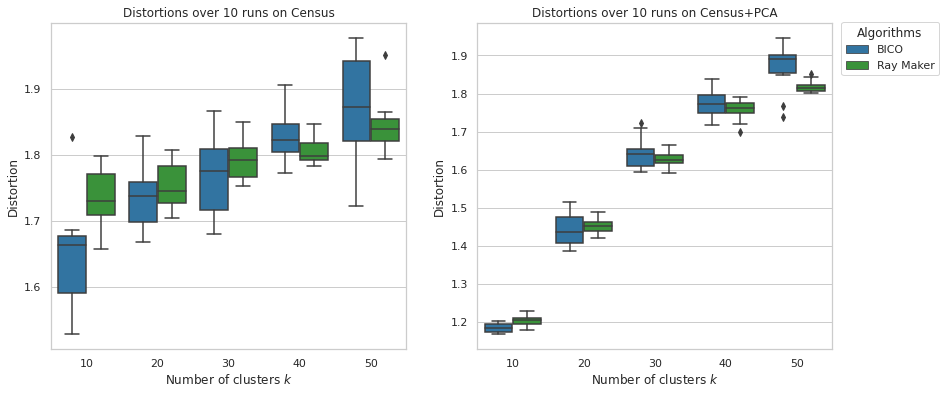

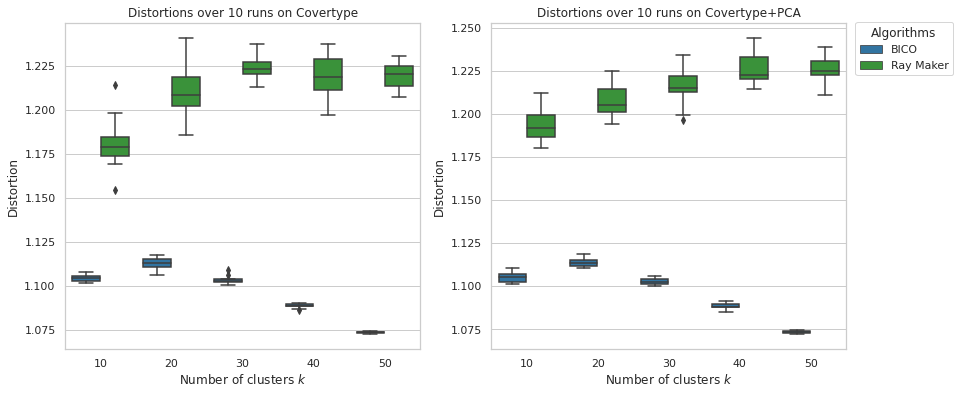

In [23]:
datasets = ["Caltech", "Census", "Covertype"]

for ds in datasets:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for i, dataset in enumerate([ds, f"{ds}+PCA"]):
        con_census = df_cost_data.dataset == dataset
        cond_ray_maker = df_cost_data.algorithm == 'Ray Maker' 
        cond_bico = df_cost_data.algorithm == 'BICO' 
        cond_skm = df_cost_data.algorithm == 'StreamKM++' 
        df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico)].copy()
        df_filtered.sort_values(by="algorithm", inplace=True)

        ax = axes[i]
        sns.boxplot(x="k", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
        ax.set_xlabel("Number of clusters $k$")
        ax.set_ylabel("Distortion")
        if i == 1:
            ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
            ax.get_legend().remove()
        ax.set_title(f"Distortions over 10 runs on {dataset}");
    # fig.savefig(f"figures-skadi/{ds}-with-and-without-PCA-distortions-BICO-Ray-Maker.pdf", bbox_inches="tight")

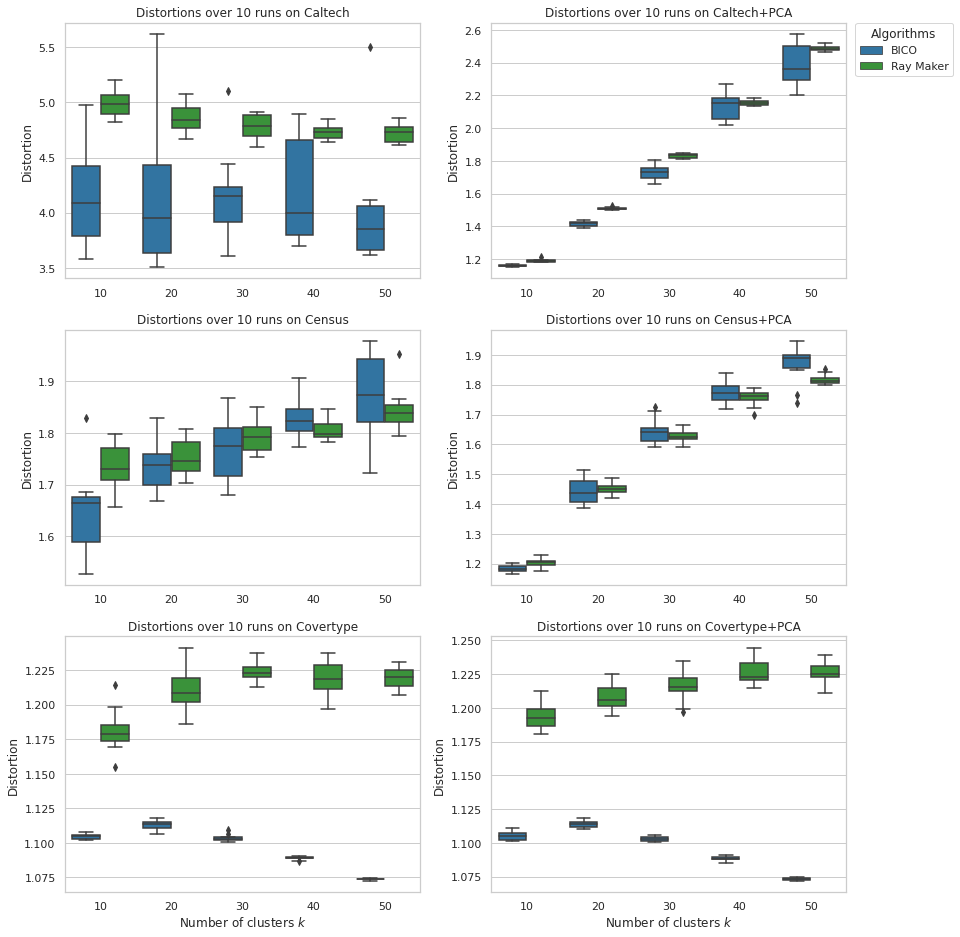

In [24]:
datasets = ["Caltech", "Caltech+PCA", "Census", "Census+PCA", "Covertype", "Covertype+PCA"]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))

for i, dataset in enumerate(datasets):
    con_census = df_cost_data.dataset == dataset
    cond_ray_maker = df_cost_data.algorithm == 'Ray Maker' 
    cond_bico = df_cost_data.algorithm == 'BICO' 
    cond_skm = df_cost_data.algorithm == 'StreamKM++' 
    df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico)].copy()
    df_filtered.sort_values(by="algorithm", inplace=True)
    
    row_index = i // 2
    column_index = i % 2
    ax = axes[row_index, column_index]
    sns.boxplot(x="k", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.set_xlabel("Number of clusters $k$" if i > 3 else "")
    ax.set_ylabel("Distortion")
    if i == 1:
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    else:
        ax.get_legend().remove()
    ax.set_title(f"Distortions over 10 runs on {dataset}");


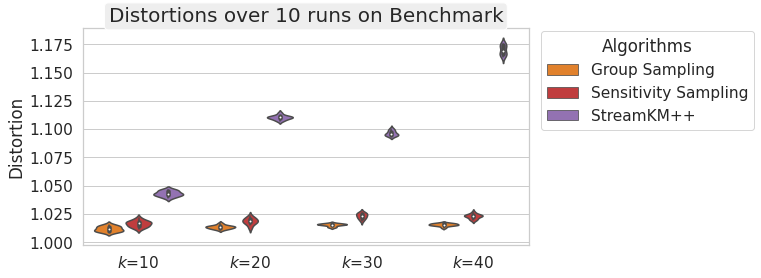

In [25]:
con_census = df_cost_data.dataset == 'Benchmark'
cond_ray_maker = df_cost_data.algorithm == 'Sensitivity Sampling'
cond_bico = df_cost_data.algorithm == 'Group Sampling'
cond_skm = df_cost_data.algorithm == 'StreamKM++' 
df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico | cond_skm)].copy()
df_filtered.sort_values(by=["algorithm", "k"], inplace=True)
df_filtered["k_formatted"] = "$k$=" + df_filtered["k"].astype(str)

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.violinplot(x="k_formatted", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("Distortion")
    ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    ax.set_title(f"Distortions over 10 runs on {df_filtered.dataset.unique()[0]}",
                fontdict={"size": 20}, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"));
    
    # fig.savefig(f"figures-skadi/violin-Benchmark-GS-SS-StreamKM.pdf", bbox_inches="tight")

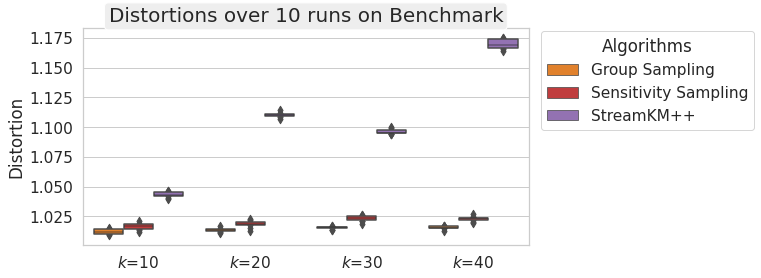

In [26]:
con_census = df_cost_data.dataset == 'Benchmark'
cond_ray_maker = df_cost_data.algorithm == 'Sensitivity Sampling'
cond_bico = df_cost_data.algorithm == 'Group Sampling'
cond_skm = df_cost_data.algorithm == 'StreamKM++' 
df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico | cond_skm)].copy()
df_filtered.sort_values(by=["algorithm", "k"], inplace=True)
df_filtered["k_formatted"] = "$k$=" + df_filtered["k"].astype(str)

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxenplot(x="k_formatted", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("Distortion")
    ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    ax.set_title(f"Distortions over 10 runs on {df_filtered.dataset.unique()[0]}",
                fontdict={"size": 20}, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"));
    
    # fig.savefig(f"figures-skadi/boxplot-Benchmark-GS-SS-StreamKM.pdf", bbox_inches="tight")